In [256]:
DENSITY_MAX = 0.13
V_MAX = 50.0       # Km / h

def flux_density_func(density):
    return density * speed_density_func(density)

def speed_density_func(density):
    SLOPE_SEG_1 = -1.8
    TRANSITION_SEG_1_TO_2 = 0.0598
    TRANSITION_SEG_2_TO_3 = 0.095
    SPEED_TRANSITION_2_TO_3 = 2.3
    
    SPEED_TRANSITION_1_TO_2 = V_MAX + (SLOPE_SEG_1 * TRANSITION_SEG_1_TO_2)
    SLOPE_SEG_2 = (SPEED_TRANSITION_2_TO_3 - SPEED_TRANSITION_1_TO_2) / (TRANSITION_SEG_2_TO_3 - TRANSITION_SEG_1_TO_2)
    
    SLOPE_SEG_3 = (0 - SPEED_TRANSITION_2_TO_3) / (DENSITY_MAX - TRANSITION_SEG_2_TO_3)
    
    if density < 0:
        return V_MAX
    if density > DENSITY_MAX:
        return 0
    
    return V_MAX + ((-V_MAX * density) / DENSITY_MAX)
    
    if density < TRANSITION_SEG_1_TO_2:
        return V_MAX + (SLOPE_SEG_1 * density)
    elif density < TRANSITION_SEG_2_TO_3:
        SEG_2_Y_INTERCEPT = (SLOPE_SEG_2 * (0 - TRANSITION_SEG_1_TO_2)) + SPEED_TRANSITION_1_TO_2
        return SEG_2_Y_INTERCEPT + (SLOPE_SEG_2 * density)
    else:
        SEG_3_Y_INTERCEPT = (SLOPE_SEG_3 * (0 - TRANSITION_SEG_2_TO_3)) + SPEED_TRANSITION_2_TO_3
        return SEG_3_Y_INTERCEPT + (SLOPE_SEG_3 * density)
    


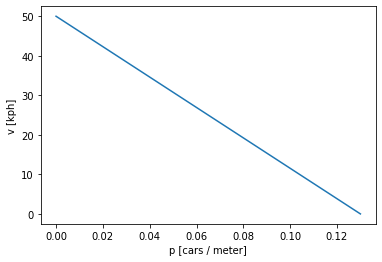

In [257]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(0.0, 0.13, num=300)
y = np.zeros(300)
for i in range(len(x)):
    y[i] = speed_density_func(x[i])
    
plt.ylabel('v [kph]')
plt.xlabel('p [cars / meter]')
plt.plot(x,y)

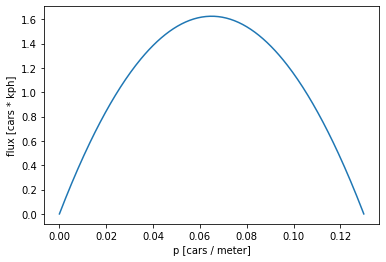

In [258]:
plt.ylabel('flux [cars * kph]')
plt.xlabel('p [cars / meter]')
plt.plot(x,x*y)

In [259]:
LENGTH = 1000 # Meters
SPATIAL_SEGMENTS = 100 # segments
DELTA_X = LENGTH / SPATIAL_SEGMENTS # Segment length [meters]
x = DELTA_X * np.arange(SPATIAL_SEGMENTS) # Cars / Meter
p = (0.02 * np.sin(x * 0.04)) + 0.05
# p = 0.1 * np.ones(SPATIAL_SEGMENTS)

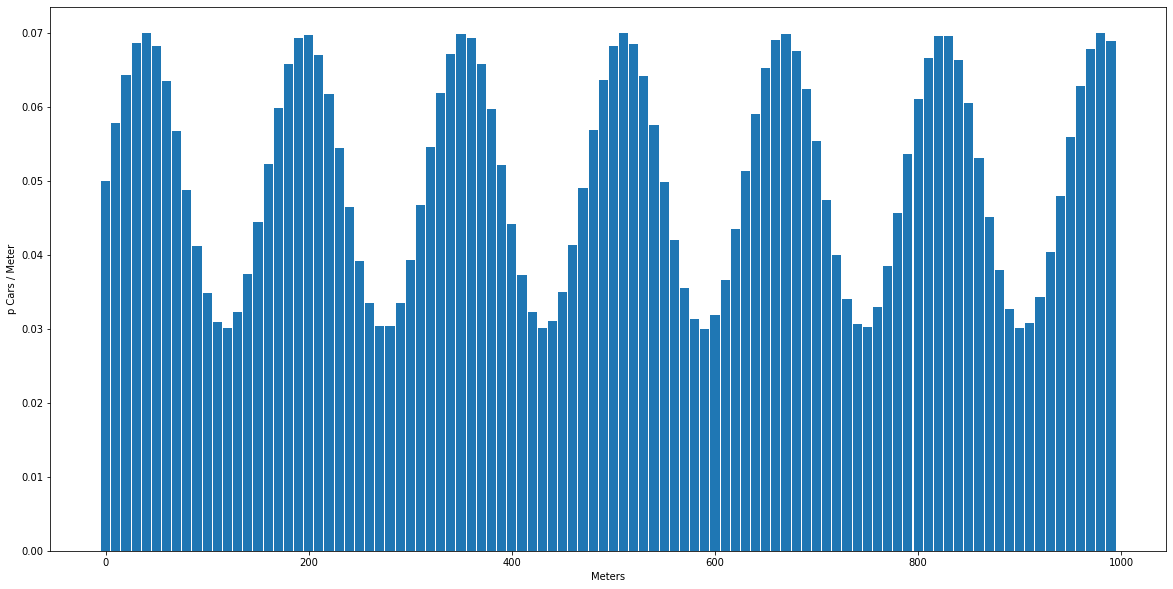

In [260]:
plt.figure(figsize=(20,10))
plt.bar(x,p, width=DELTA_X*0.9)
plt.xlabel('Meters')
plt.ylabel('p Cars / Meter')
plt.show()

In [261]:
DENSITY_IN = 0.06
DENSITY_OUT = 0.02
FLUX_IN = flux_density_func(DENSITY_IN)
FORE_SIGHT = [0.1, 0.4, 0.2, 0.2, 0.05, 0.05]

def tick(p, dt, speed_mask=None):
    PADDING = len(FORE_SIGHT)
    
    # Make P artifically bigger for boundary conditions 
    p = np.concatenate([DENSITY_IN * np.ones(PADDING), p], axis=0)
    p = np.concatenate([p, DENSITY_OUT * np.ones(PADDING)], axis=0)
    
    p_next = np.zeros(len(p))
    speeds = np.zeros_like(p_next) 
    fluxes = np.zeros_like(p_next)
    for i in range(len(p)):
        speed_i = 0
        for j in range(len(FORE_SIGHT)):
            if i + j >= len(FORE_SIGHT):
                speed_i += speed_density_func(p[i]) * FORE_SIGHT[j]
            else:
                if speed_mask is not None:
                    speed_i += speed_density_func(p[i + j]) * FORE_SIGHT[j] * speed_mask[i+j-PADDING]
                else:
                    speed_i += speed_density_func(p[i + j]) * FORE_SIGHT[j]
                
        speeds[i] = speed_i
    
    if speed_mask is not None:
        speeds[PADDING:-PADDING] *= speed_mask
    
    for i in range(len(p)):
        flux_i = (p[i-1] * speeds[i - 1]) - (p[i] * speeds[i])
        fluxes[i] = flux_i * dt / DELTA_X
        
#     if speed_mask is not None:
#         fluxes[PADDING:-PADDING] *= speed_mask
    
    flux_maxs = (DENSITY_MAX * np.ones(len(p))) - p
    flux_mins = -p
    fluxes = np.minimum(fluxes, flux_maxs)
    fluxes = np.maximum(fluxes, flux_mins)
    
    fluxes[0] = flux_density_func(DENSITY_IN) * dt / DELTA_X
    
    # Smooth fluxes and future density
    fluxes = np.convolve(fluxes,[0.20,0.60,0.20], 'same')
    p_next = p + fluxes
    p_next = np.convolve(p_next,[0.20,0.60,0.20], 'same')
    
    return p_next[PADDING:-PADDING], speeds[PADDING:-PADDING], fluxes[PADDING:-PADDING]
    

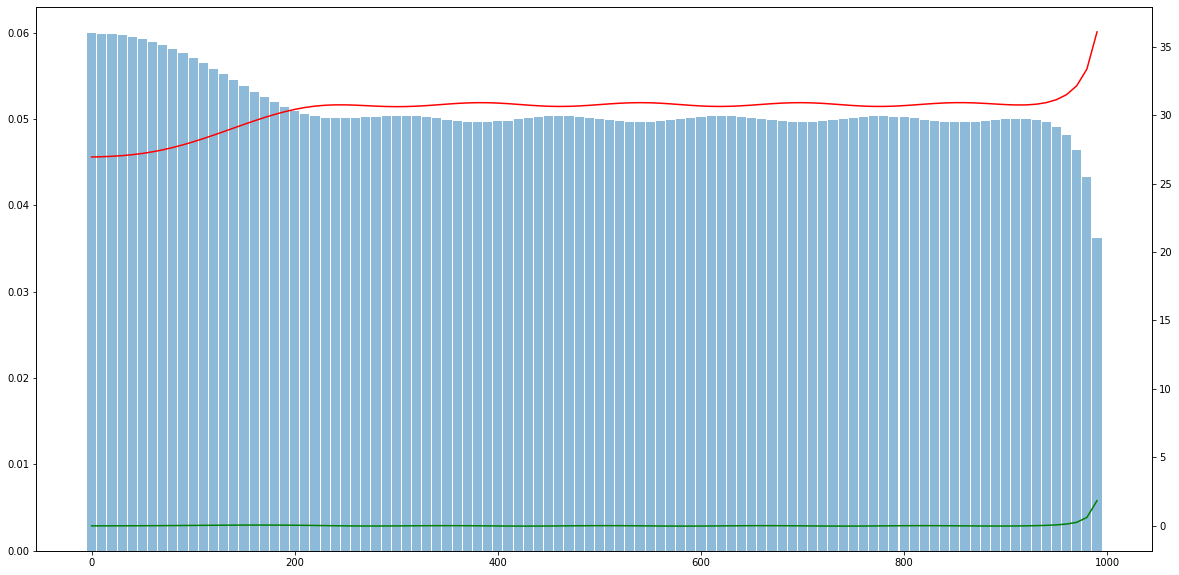

In [262]:
ADVANCE = 100

p_next = p
for i in range(ADVANCE):
    p_next, speeds, fluxes = tick(p_next, 0.1)

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()

ax1.bar(x,p_next, width=DELTA_X*0.9, alpha=0.5)

ax2.plot(x, speeds,  'r-')
# ax2.set_ylim(ymin=0)

ax2.plot(x, fluxes * 1000,  'g-')
# ax2.set_ylim(ymin=0)

plt.show()

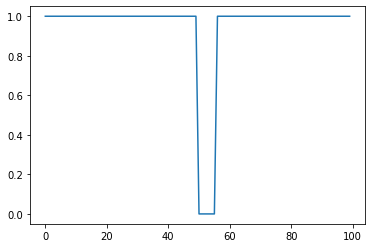

In [263]:
speed_mask = np.ones(SPATIAL_SEGMENTS)
speed_mask[50:50+len(FORE_SIGHT)] = 0.0
plt.plot(speed_mask)
plt.show()


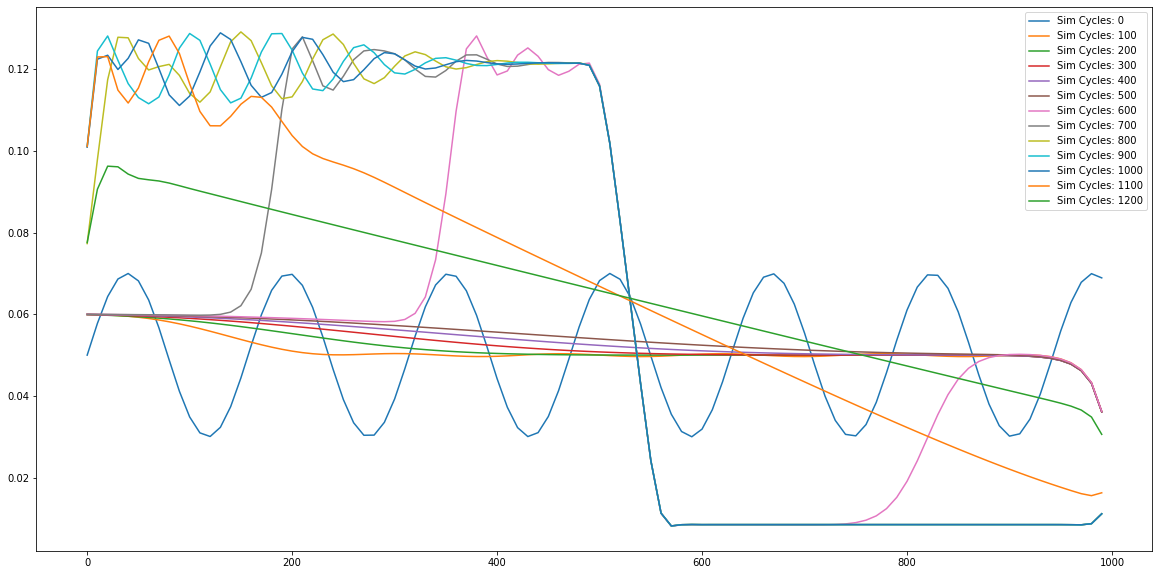

In [264]:
DELTA_TIME = 0.1

EXPERIMENTS = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
# EXPERIMENTS = [600, 900, 1200, 5000]
densities = []
for i in range(len(EXPERIMENTS)):
    densities.append(p.copy())
    for e in range(EXPERIMENTS[i]):
        if 1000 > e > 500:
            densities[i], _, _ = tick(densities[i], DELTA_TIME, speed_mask=speed_mask)
        else:
            densities[i], _, _ = tick(densities[i], DELTA_TIME)


plt.figure(figsize=(20,10))
for i in range(len(EXPERIMENTS)):
    plt.plot(x, densities[i], label=f"Sim Cycles: {EXPERIMENTS[i]}")
plt.legend(loc='upper right')
plt.show()

In [265]:
densities[-3][-10]

0.008506448488734882

0.0007199999999999999


<IPython.core.display.Javascript object>


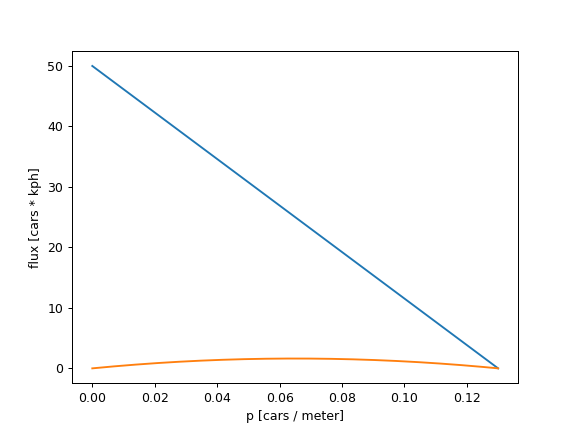

ValueError: x and y must have same first dimension, but have shapes (50,) and (3, 50)

In [190]:
%matplotlib notebook
STABILITY_FACTOR = 0.01 # Must be less than 1
KPH_TO_MPS = 1 / 3.6
DELTA_TIME = STABILITY_FACTOR * DELTA_X / (V_MAX * KPH_TO_MPS)
print(DELTA_TIME / DELTA_X)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

SIMULATION_TIME = 100
TICKS_PER_DRAW = 1

for i in range(0,int(SIMULATION_TIME / DELTA_TIME / TICKS_PER_DRAW)):
    for i in range(TICKS_PER_DRAW):
        p = tick(p, DELTA_TIME)
    ax.clear()
    ax.plot(x,p)
    fig.canvas.draw()


In [33]:
from sympy.solvers import nsolve
from sympy import Symbol
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols

In [34]:
DENSITY_MAX = 0.13
V_MAX = 50.0       # Km / h

LENGTH = 1000 # Meters
SPATIAL_SEGMENTS = 20 # segments
DELTA_X = LENGTH / SPATIAL_SEGMENTS # Segment length [meters]
x = DELTA_X * np.arange(SPATIAL_SEGMENTS) # Cars / Meter
p = (0.02 * np.sin(x * 0.01)) + 0.05

In [35]:
plt.plot(x,p)

In [40]:
def speed_from_density(density):
    return (V_MAX + ((-V_MAX * density) / DENSITY_MAX))

def solver_tick(p, dt):
    future_densities  = symbols(f'fp0:{len(p)}')
    current_densities = symbols(f'p0:{len(p)}')
    equations = []
    for i in range(len(p)):
        if i == 0:
            eq = (future_densities[0] - 0.060)
            equations.append(eq)
            eq = (current_densities[0] - 0.060)
            equations.append(eq)
        elif i == len(p) - 1:
            eq = (future_densities[len(p) - 1])
            equations.append(eq)
            eq = (current_densities[len(p) - 1])
            equations.append(eq)
        else:
            flux_prev = future_densities[i-1] * speed_from_density(future_densities[i-1])
            flux_cur = future_densities[i] * speed_from_density(future_densities[i])
            eq = future_densities[i]  - current_densities[i] - ((flux_prev - flux_cur) * (dt / DELTA_X))
            equations.append(eq)
            eq = current_densities[i] - p[i]
            equations.append(eq)
    
    solution = nsolve(equations, current_densities + future_densities, np.concatenate([p,p*1.5],axis=0), verify=False)
    return solution
solution = solver_tick(p, 0.1)

In [41]:
p_next = np.array(solution).astype(np.float64).flatten()[SPATIAL_SEGMENTS:]

In [42]:
plt.plot(x,p_next)

<IPython.core.display.Javascript object>


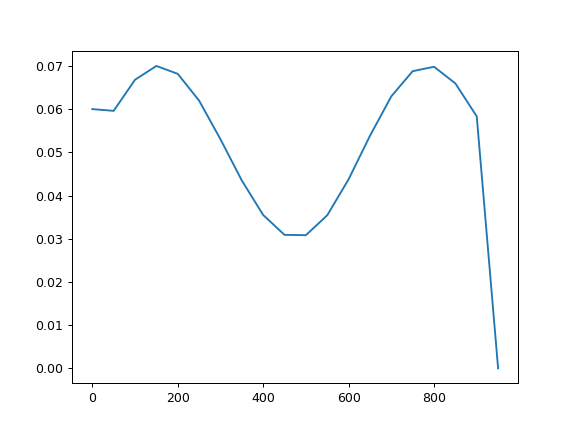

Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved


KeyboardInterrupt: 

In [43]:
%matplotlib notebook

DELTA_TIME = 10.0

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

SIMULATION_TIME = 1000
TICKS_PER_DRAW = 1

for i in range(0,int(SIMULATION_TIME / DELTA_TIME / TICKS_PER_DRAW)):
    for i in range(TICKS_PER_DRAW):
        p_next = solver_tick(p, DELTA_TIME)
        p_next = np.array(solution).astype(np.float64).flatten()[SPATIAL_SEGMENTS:]
        p = p_next
        print(f"Solved")
    ax.clear()
    ax.plot(x,p)
    fig.canvas.draw()